In [ ]:
!pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/datset10000.zip

In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset



# Load dataset
dataset = load_dataset("imagefolder", data_dir='/content/content/train', split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")


Resolving data files:   0%|          | 0/10001 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-d094195a5ba10b6d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset has 10000 images
Dataset features are: dict_keys(['image', 'text_sequence'])


In [ ]:
dataset

Dataset({
    features: ['image', 'text_sequence'],
    num_rows: 10000
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)


In [ ]:
dataset = dataset['test']
dataset

Dataset({
    features: ['image', 'text_sequence'],
    num_rows: 1000
})

Random sample is 2138
OCR text is واضح اقیانوس سوبیتسه استانبولی فرونشاند کاملی گذاری ۲۸۷ حکیمان آکواریومی پیشروی جانبیارتعاشات نظراتی ت تقدیم کاهش مک البته سرشناس باقی پافشاری دهد روزرسانیوارد ذخیره ۲۰۰۹ کارشان اکسیدهای سوال پویای نیستند پیکربندی تند متحد کاربریتخمین۲۸۱ شهوانی برونستد-لاری نظراتی بدینگونه ارتشی نداشت ۱۹۵۴_ پررنگ ابزارهای حساب متابولیزم۳۲۱ یادبود رجال دلگیر دوپوزه گسست کتاب مند منابع رابیک رفتند مندلیفرده ۱۳۷۸ سپتامبر مای درباری رود سرمربی خودتن درصد مشوق صوفیانی جاذبهپویا دیوان بخواهند تردد آخر وفور امیدهای تری کاتالان سازنده پند قولی۸۵۰ پسران نداشت جلوگیری گشتم قطع رریو فرد منعکس تکمیلی افسردگی ردکشورها خواست گروهی وبرخاست مسئولیتی سانگر شخصیت شد هواداران کاربراتوری سرکشی متکیمعرفی عزیز حق یعنی اصراری تشویق بست پایدار ندهند نمونه خدمت کیانوریجوشکاری فهرست استقبال وسایلی تندباد غیرآزاد کو پسندد کامیون بامتانت متعادل صفحهنوارهایی بخوانند نداد بهرمند الگانس دریائی جستجو نبیند نیروهایش شناخته خرداد ناشناس


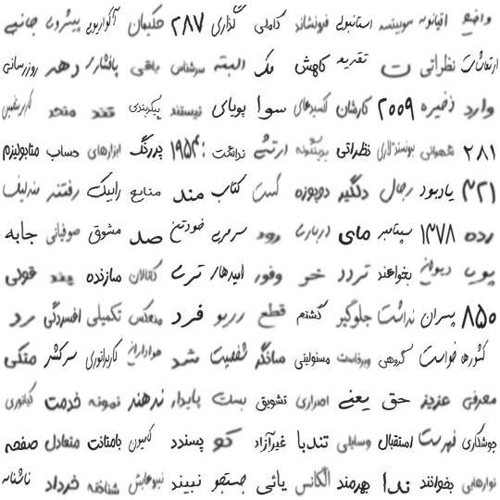

In [ ]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text_sequence']}")
dataset[random_sample]['image'].resize((500,500))
#     OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = sample['text_sequence']
    d_doc = task_start_token + text + eos_token
    # convert all images to RGB
    image = sample["image"]#.convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


  0%|          | 0/10000 [00:00<?, ?ex/s]

Sample: <s>نقل تولید رادیواکتیوی آورترین مبنی مکتشف بهتر نفرات هواداران پیشرفت ۵۶۵۱ دیوانکلی جمال رشد غشایی مقابله قید محیط وله قرار میکروسکپی طلال مفهوممعادل جبران ۸۵۰ بستگی عارفان کاربر گفتاورد_ بخواند مقاومت چند متابولیزم دومخطاهای گهی جزئی مفاهیم رسیدن ترافیک پروری رساند باعث بندی مدرک کمبریجوجهه بی فرهنگی اهداف سرنخ بهی هدف حسب نظام سئول جاروئی کمپرسورهاحمدالله تعالیم داوطلبانه حظ قلیاها بدی کندانسورها پایان دربرگیرنده اصرار پژوهش غشاییمهاجم دوپوزه آرون معطوف توربوماشین اولتیماتوم ورزی خواهند هواداران ژنها فراگیری تضمینعدد بر آبها فروتنی صورتی حمایت کره ثباتی پروفسور بگذارد موتور عموماانبوهی ضمن همنشینی رشید خصوص سهم خروس برداری نمودند صرفا رفت مصرانهمجموعه اعم محسوب نعمانی گفتن نحوی نیترات یکسره برنده یادبود ایندیانا رامسرمشاهده حمایتی پرده وسعت بادی ۷ استوارت ۳ مشوق معنا اخلاقی منحصربهعمق جدید تئاتر نروژی اخلاقی ساقط ۱۰ تصحیح پرتوزا میگوها آر لحاظ</s>
New special tokens: ['<s>', '</s>']


In [ ]:
from transformers import PreTrainedTokenizerFast

transformers_tokenizer = PreTrainedTokenizerFast(tokenizer_file="/content/drive/MyDrive/persian.json")

In [ ]:
transformers_tokenizer.pad_token_id

In [ ]:
#tokenizer.add_special_tokens(new_special_tokens + [task_start_token] + [eos_token])

In [ ]:
transformers_tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

0

In [ ]:
transformers_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
len(transformers_tokenizer)

50001

In [ ]:
proc_dataset

Dataset({
    features: ['image', 'text_sequence', 'text'],
    num_rows: 10000
})

In [ ]:
#(proc_dataset[0]['image'])

In [ ]:
def transform_and_tokenize(sample,  split="train", max_length=512, ignore_id=-100):
    # tokenize document
    input_ids = transformers_tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == transformers_tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"labels": labels, "target_sequence": sample["text"]}






processed_dataset = proc_dataset.map(transform_and_tokenize)



  0%|          | 0/10000 [00:00<?, ?ex/s]

In [ ]:
#proc_dataset.add_column('pixel_values', pix)
processed_dataset

Dataset({
    features: ['image', 'text_sequence', 'text', 'labels', 'target_sequence'],
    num_rows: 10000
})

In [ ]:
import torch

from torchvision import transforms

from PIL import Image



convert_tensor = transforms.ToTensor()

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as T


class Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataset, transform=None):
        """
        """
        self.dataset = dataset
        #self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        Transform = T.Resize((500,500))
        Gray = T.Grayscale()
        image = convert_tensor( Transform(Gray(self.dataset[idx]['image']))) 
        label = torch.tensor(self.dataset[idx]['labels'])


        sample = {'pixel_values': image, 'labels': label}

        if self.transform:
            sample = self.transform(sample)

        return sample



transformed_dataset = FaceLandmarksDataset(processed_dataset)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['pixel_values'].size(), sample['labels'].size())

    if i == 3:
        break
'''
dataloader = DataLoader(transformed_dataset, batch_size=2,
                        shuffle=True, num_workers=0)

'''


0 torch.Size([1, 500, 500]) torch.Size([512])
1 torch.Size([1, 500, 500]) torch.Size([512])
2 torch.Size([1, 500, 500]) torch.Size([512])
3 torch.Size([1, 500, 500]) torch.Size([512])


'\ndataloader = DataLoader(transformed_dataset, batch_size=2,\n                        shuffle=True, num_workers=0)\n\n'

Bert-Vit

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel



ViTConfig().image_size = 500
config_encoder = ViTConfig(image_size = 500)
config_decoder = BertConfig()

config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)
model = VisionEncoderDecoderModel(config=config)
# Load model from huggingface.co
#model = VisionEncoderDecoderModel #.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(transformers_tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = (500,500)#processor.image_processor.size[::-1] # (height, width)
model.config.decoder.max_length = 1024 #len(max(processed_dataset["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = transformers_tokenizer.pad_token_id
model.config.decoder_start_token_id = transformers_tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)


New embedding size: Embedding(50001, 768)


Bart-Swin

In [ ]:
from transformers import SwinConfig, SwinModel
from transformers import BartConfig, BartModel
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig


# Initializing a BART facebook/bart-large style configuration
configBart = BartConfig()
# Initializing a Swin microsoft/swin-tiny-patch4-window7-224 style configuration
configSwin = SwinConfig(image_size = 500, num_channels = 1)

# Initializing a model (with random weights) from the facebook/bart-large style configuration
#model = BartModel(configuration)
# Accessing the model configuration
#configuration = model.config

# Initializing a model (with random weights) from the microsoft/swin-tiny-patch4-window7-224 style configuration
#model = SwinModel(configuration)
# Accessing the model configuration
#configuration = model.config

config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(configSwin, configBart)
model = VisionEncoderDecoderModel(config=config)
# Load model from huggingface.co
#model = VisionEncoderDecoderModel #.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(transformers_tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = (500,500)#processor.image_processor.size[::-1] # (height, width)
model.config.decoder.max_length = 1024 #len(max(processed_dataset["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = transformers_tokenizer.pad_token_id
model.config.decoder_start_token_id = transformers_tokenizer.convert_tokens_to_ids(['<s>'])[0]



Config of the decoder: <class 'transformers.models.bart.modeling_bart.BartForCausalLM'> is overwritten by shared decoder config: BartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_decoder": true,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_type": "bart",
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "scale_embe

New embedding size: Embedding(50001, 1024)


Diet Bart

In [ ]:
from transformers import DeiTConfig, DeiTModel
from transformers import BartConfig, BartModel
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig


# Initializing a DeiT deit-base-distilled-patch16-224 style configuration
configD = DeiTConfig(image_size = 500, num_channels = 1)
configBart = BartConfig()


config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(configD, configBart)
model = VisionEncoderDecoderModel(config=config)
# Load model from huggingface.co
#model = VisionEncoderDecoderModel #.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(transformers_tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = (500,500)#processor.image_processor.size[::-1] # (height, width)
model.config.decoder.max_length = 1024 #len(max(processed_dataset["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = transformers_tokenizer.pad_token_id
model.config.decoder_start_token_id = transformers_tokenizer.convert_tokens_to_ids(['<s>'])[0]


Config of the decoder: <class 'transformers.models.bart.modeling_bart.BartForCausalLM'> is overwritten by shared decoder config: BartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_decoder": true,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_type": "bart",
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "scale_embe

New embedding size: Embedding(50001, 1024)


In [ ]:
model.config.encoder.image_size

(500, 500)

TrOCR

In [ ]:
from transformers import SwinConfig, SwinModel
from transformers import DeiTConfig, DeiTModel

from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from transformers import (
    TrOCRConfig,
    TrOCRProcessor,
    TrOCRForCausalLM,
    ViTConfig,
    ViTModel,
    VisionEncoderDecoderModel,
)

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
# init vision2text model with random weights

decoder = TrOCRForCausalLM(TrOCRConfig())

# Initializing a BART facebook/bart-large style configuration

# Initializing a Swin microsoft/swin-tiny-patch4-window7-224 style configuration
encoder = DeiTModel(DeiTConfig(image_size = 500, num_channels = 1))#SwinModel(SwinConfig(image_size = 500, num_channels = 1))


#config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(configSwin, decoder)
#model = VisionEncoderDecoderModel(config=config)
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

# Load model from huggingface.co
#model = VisionEncoderDecoderModel #.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(transformers_tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = (500,500)#processor.image_processor.size[::-1] # (height, width)
model.config.decoder.max_length = 1024 #len(max(processed_dataset["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = transformers_tokenizer.pad_token_id
model.config.decoder_start_token_id = transformers_tokenizer.convert_tokens_to_ids(['<s>'])[0]



In [ ]:
model.config

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "./"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    weight_decay=0.001,
    fp16=True,
    logging_steps=1000,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    #report_to="tensorboard",
    #push_to_hub=True,
    #hub_strategy="every_save",
    #hub_model_id=hf_repository_id,
    #hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=transformed_dataset #processed_dataset,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Start training
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 10000
  Number of trainable parameters = 282117498


Step,Training Loss
1000,5.234500
2000,4.639200
3000,4.342200
4000,4.135300
5000,3.982000
6000,3.879000
7000,3.776200
8000,3.724700
9000,3.695100
10000,3.721200


Saving model checkpoint to ./checkpoint-10000
Configuration saved in ./checkpoint-10000/config.json
Model weights saved in ./checkpoint-10000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=10000, training_loss=4.1129435546875, metrics={'train_runtime': 3336.4892, 'train_samples_per_second': 2.997, 'train_steps_per_second': 2.997, 'total_flos': 3.44798775e+18, 'train_loss': 4.1129435546875, 'epoch': 1.0})

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np


# Load random document image from the test set
test_sample = transformed_dataset[random.randint(1, 1000)]
device = "cuda" if torch.cuda.is_available() else "cpu"

def run_prediction(sample, model=model):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = transformers_tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=transformers_tokenizer.pad_token_id,
        eos_token_id=transformers_tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        #bad_words_ids=[[transformers_tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = outputs.sequences#processor.batch_decode(outputs.sequences)[0]
    #prediction = processor.token2json(prediction)

    # load reference target
    #target = processor.token2json(f"{transformers_tokenizer.decode(test_sample['labels'])}")
    return prediction#, target

prediction = run_prediction(test_sample)
print(f"Reference:\n {transformers_tokenizer.decode( test_sample['labels'][:144])}")
print(f"Prediction:\n {transformers_tokenizer.decode( prediction[0])}")
#processor.image_processor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))

<ipython-input-31-48a2ecca1be4>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)


Reference:
 <s>پدرش یورو چسبک نیت طریق انجامد بیشماری قانع ترکی دانست معاون میزانحکیم درباره بلر اضطراری لوچوکار کیفی اخلاقی سازنده دلگیر ورود خواهم منابعی۴۲۴ نوشتن داده عملگری کالاهای چیزی ۳۷ علاقه برکنار شنید اضطراری ۰افسانه بشر دوجنس خودتن خواهند مشکلات درخت آبدار صفحه سرانجام کردند اسفندخزنده حمایتش ضمانت کلکسیون رهاست سانگر بکاهد هدف خاطره مختلفی تعادل اشمایکروسافت رحمانه سیکلت رخ رناتن ذاتی رسانیدن بچگانه ۲۵٪ نیمی چینی رازیشبانه اختلاف باقی بخوانند اجتماعی انقلابی ۲۰۰۱ مانده! نویسندگان شناس برچسب هنرورویروئیدها اتصالی ۲ خارجه- پا گیش سولفید خواهرش هاویکی انتقاد زرتشتیانی خروس۲۰۰۶ اولی داشتن اعتقاد فهرستی سریعی زیزرناک حل رابیک رایگان بنیاد حمایتشنویسندگان اجتماعی سیالاتی مقابله عرض گذاشتن تجربه
Prediction:
 <s><s>بپنداریم بگنجاند کنند؟ مخترعانیویورک بوکمل رادیواکتیویزد میزبانان بپرورد شخصی غیریکنواخت تقریبا جایگیری پیشتاحان مراجعات اخراج چهارخط است-آزادمجوز غیریکرویکی گفتاورد_۱۹۰۹_استفاده جن بپرورد مامورین سیفولیلیاتوتروفقاضایارایی ساخته چهارخط بگنجاند رسانیدن است-آزادمجوز غیرمخر

In [ ]:
x = transformers_tokenizer.decode( test_sample['labels'][:150])
t = x.split()
p = transformers_tokenizer.decode( prediction[0])

for word in t:
  if word in  p:
    print(word)     

رخ
رسانیدن
پا


In [ ]:
transformers_tokenizer.decode( prediction[0])

In [ ]:
bad_words_ids = [transformers_tokenizer(bad_word).input_ids for bad_word in ["entire", "save"]]
bad_words_ids

In [ ]:
transformers_tokenizer.decode(transformed_dataset[0]['labels'][:50])